In [225]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import eispac
from sunraster.instr.spice import read_spice_l2_fits
import h5py
from correct_2d_psf import get_fwd_matrices, correct_spice_raster
import scipy
from scipy import ndimage

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFitSingle, SpectrumFit2D
from copy import deepcopy

In [3]:
spice_raster = read_spice_l2_fits("../../src/SPICE/20221022/lvl2/solo_L2_spice-n-ras_20221022T205536_V06_150995382-000.fits")

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59874.871951 from DATE-OBS.
Set MJD-BEG to 59874.871951 from DATE-BEG.
Set MJD-AVG to 59874.950052 from DATE-AVG.
Set MJD-END to 59875.028152 from DATE-END'. [astropy.wcs.wcs]


In [4]:
spice_raster.keys()

dict_keys(['O III 703 / Mg IX 706 (Merged)', 'S IV 750 - Peak', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'S V 786 / O IV 787 (Merged)', 'N III 991 (Merged)'])

In [228]:
with fits.open("../../src/SPICE/20221022/lvl2/solo_L2_spice-n-ras_20221022T205536_V06_150995382-000.fits") as hdul:
    hdul.info()
    print(hdul[3].data.shape)

Filename: ../../src/SPICE/20221022/lvl2/solo_L2_spice-n-ras_20221022T205536_V06_150995382-000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  O III 703 / Mg IX 706 (Merged)    1 PrimaryHDU     408   (224, 832, 80, 1)   float32   
  1  S IV 750 - Peak    1 ImageHDU       403   (224, 832, 50, 1)   float32   
  2  N IV 765 - Peak    1 ImageHDU       403   (224, 832, 50, 1)   float32   
  3  Ne VIII 770 - Peak    1 ImageHDU       403   (224, 832, 50, 1)   float32   
  4  S V 786 / O IV 787 (Merged)    1 ImageHDU       409   (224, 832, 56, 1)   float32   
  5  N III 991 (Merged)    1 ImageHDU       409   (224, 832, 56, 1)   float32   
  6  VARIABLE_KEYWORDS    1 BinTableHDU    385   1R x 27C   [224D, 224I, 224I, 224I, 224I, 224I, 224E, 224E, 224E, 224E, 7I, 7I, 7I, 7I, 7J, 7J, 7J, 7J, 5152A, 224D, 224D, 80D, 50D, 50D, 50D, 56D, 56D]   
  7  WCSDVARR      1 ImageHDU        28   (224,)   float64   
  8  WCSDVARR      2 ImageHDU        28   (224,)   float64   
(1, 50, 8

In [5]:
spice_NeVIII_770_window = spice_raster['Ne VIII 770 - Peak']

In [229]:
spice_NeVIII_770_window.data.shape

(1, 50, 832, 224)

In [6]:
spice_NeVIII_770_window.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'WAVE' 'TIME' 
CRVAL : 0.09227812314166667 0.13431963613527778 7.699282680000001e-08 6747.875 
CRPIX : 112.5 416.5 25.5 1.0 
PC1_1 PC1_2 PC1_3 PC1_4  : 0.995067849204 -0.0272294805763 0.0 0.0 
PC2_1 PC2_2 PC2_3 PC2_4  : 0.361372133155 0.995067849204 0.0 0.0 
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0 0.0 1.0 0.0 
PC4_1 PC4_2 PC4_3 PC4_4  : -60.25 0.0 0.0 1.0 
CDELT : 0.0011111111111111111 0.00030500000000000004 9.751700000000001e-12 1.0 
NAXIS : 224  832  50  1

In [7]:
NeVIII_770_window_rebin = spice_NeVIII_770_window.rebin((1,50,1,1))[0,0,:,:]

In [8]:
NeVIII_770_window_rebin_map = sunpy.map.Map(NeVIII_770_window_rebin.data, NeVIII_770_window_rebin.meta)

In [200]:
NeVIII_770_window_rebin_map.date_average

<Time object: scale='utc' format='isot' value=2022-10-22T22:48:04.534>

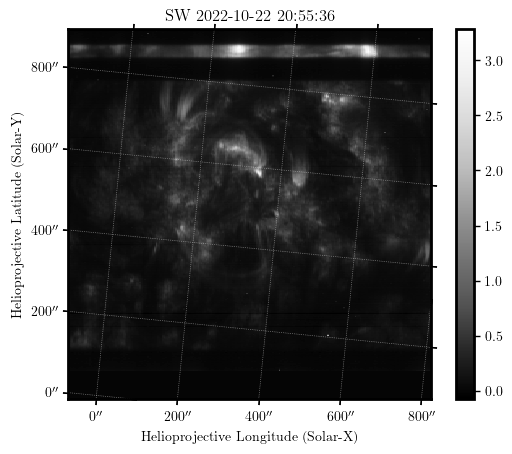

In [9]:
NeVIII_770_window_rebin_map.plot(aspect=NeVIII_770_window_rebin_map.scale.axis2/NeVIII_770_window_rebin_map.scale.axis1,
                                 cmap="Greys_r")

plt.colorbar()

In [10]:
NeVIII_770_window_wvl = spice_NeVIII_770_window.wcs.slice((0,slice(0,50),0,0)).pixel_to_world(np.arange(50)).value*1e10

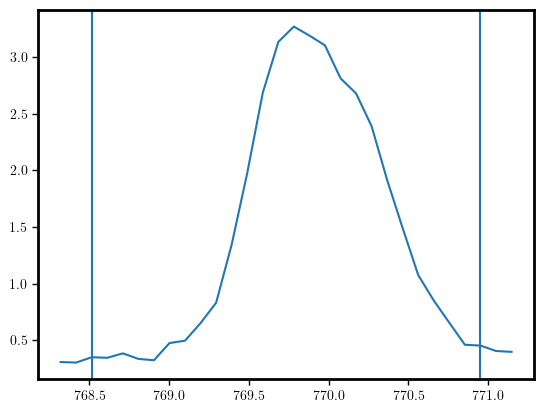

In [53]:
plt.plot(NeVIII_770_window_wvl, spice_NeVIII_770_window.data[0,:,550,110])
plt.axvline(NeVIII_770_window_wvl[10])
plt.axvline(NeVIII_770_window_wvl[35])

In [26]:
NeVIII_770_window_rebin_crop = NeVIII_770_window_rebin[200:-128,:]

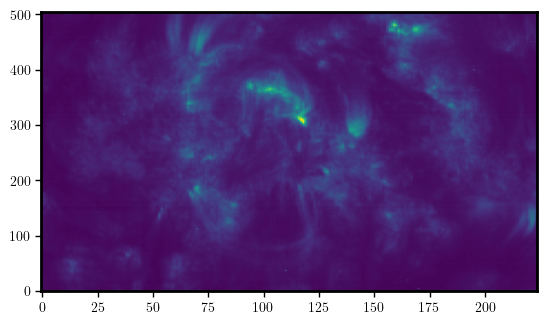

In [27]:
plt.imshow(NeVIII_770_window_rebin_crop.data,origin="lower",aspect=1/4)

In [34]:
NeVIII_770_window_rebin_crop.data.shape

(504, 224)

In [35]:
NeVIII_770_window_rebin_map_crop = NeVIII_770_window_rebin_map.submap([0,200]*u.pix,
                                                                    top_right=[224,832-129]*u.pix)

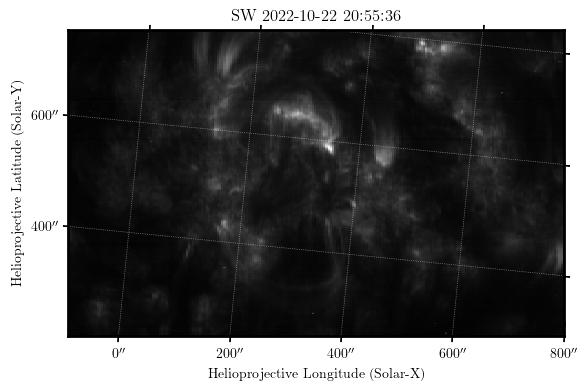

In [36]:
NeVIII_770_window_rebin_map_crop.plot(aspect=NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1,)

In [38]:
NeVIII_770_window_rebin_map_crop.save("../../src/SPICE/20221022/lvl3/NeVIII_770_int_map_205536.fits",overwrite=True)

In [39]:
NeVIII_770_window_rebin_map_crop.data.shape

(504, 224)

In [205]:
NeVIII_770_int_gradient_h = ndimage.sobel(NeVIII_770_window_rebin_map_crop.data,axis=1)
NeVIII_770_int_gradient_v = ndimage.sobel(NeVIII_770_window_rebin_map_crop.data,axis=0)
NeVIII_770_int_gradient_mag = np.sqrt(NeVIII_770_int_gradient_h**2 + NeVIII_770_int_gradient_v**2)
NeVIII_770_int_grad_map = sunpy.map.Map(NeVIII_770_int_gradient_mag,NeVIII_770_window_rebin_map_crop.meta)
NeVIII_770_int_grad_map.plot_settings['cmap'] = cmcm.batlowK
NeVIII_770_int_grad_map.plot_settings['aspect'] = NeVIII_770_int_grad_map.scale.axis2/NeVIII_770_int_grad_map.scale.axis1 

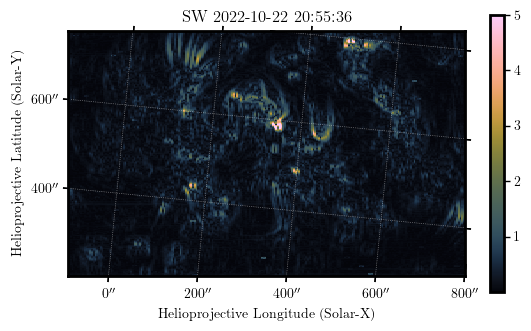

In [211]:
NeVIII_770_int_grad_map.plot(vmax=5)
plt.colorbar(shrink=0.75)

In [44]:
spice_hdr = spice_NeVIII_770_window.meta.original_header
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.0

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -13*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([5.5, 1.15])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([20.0, 4]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.21

spice_dat1 = spice_NeVIII_770_window[0,:,200:-128,:].data.transpose([2,1,0]).astype(np.float32)

spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight,
                                                                  super_fac=1, psf_thold_core=0.0005)

Correcting Ne VIII 770 - Peak; ref. wavelength=767.4415845
Computing PSF Core:
4.996230009127347 % done after 2.687753438949585 seconds
9.996428429699591 % done after 6.099763870239258 seconds
14.996626850271836 % done after 8.681953191757202 seconds
19.99682527084408 % done after 11.78737998008728 seconds
24.997023691416327 % done after 14.265941619873047 seconds
29.99722211198857 % done after 17.35108232498169 seconds
34.99742053256082 % done after 20.39623212814331 seconds
39.99761895313306 % done after 22.925238609313965 seconds
44.9978173737053 % done after 26.075465440750122 seconds
49.99801579427755 % done after 28.564749002456665 seconds
54.998214214849796 % done after 31.60968828201294 seconds
59.99841263542204 % done after 34.61733388900757 seconds
64.99861105599429 % done after 37.073057651519775 seconds
69.99880947656654 % done after 40.1043016910553 seconds
74.99900789713878 % done after 42.67922306060791 seconds
79.99920631771101 % done after 45.918909788131714 seconds
84

/home/yjzhu/Solar/spice_psf/spice_psf/util.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_masked_medfilt_inner" failed type inference due to: Use of unsupported NumPy function 'numpy.unravel_index' or unsupported use of the function.

File "../../../spice_psf/spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

During: typing of get attribute at /home/yjzhu/Solar/spice_psf/spice_psf/util.py (40)

File "../../../spice_psf/spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_i

Correcting the PSF:
42.31881380081177 s; Finished slit index 0 of 224 7 of 40 iterations taken, chi^2= 0.012829121553317635
78.47927975654602 s; Finished slit index 1 of 224 6 of 40 iterations taken, chi^2= 0.014531858681602911
111.57215309143066 s; Finished slit index 2 of 224 6 of 40 iterations taken, chi^2= 0.016077118979035722
142.1066951751709 s; Finished slit index 3 of 224 7 of 40 iterations taken, chi^2= 0.014507260233788788
170.94011974334717 s; Finished slit index 4 of 224 7 of 40 iterations taken, chi^2= 0.014026555837449245
198.02611088752747 s; Finished slit index 5 of 224 6 of 40 iterations taken, chi^2= 0.013286641466819552
224.73358869552612 s; Finished slit index 6 of 224 6 of 40 iterations taken, chi^2= 0.012660425399164035
250.6807291507721 s; Finished slit index 7 of 224 6 of 40 iterations taken, chi^2= 0.0136887081513118
280.0058150291443 s; Finished slit index 8 of 224 7 of 40 iterations taken, chi^2= 0.014818305345431836
311.2918791770935 s; Finished slit index 9

In [48]:
with h5py.File("../../src/SPICE/20221022/lvl3/NeVIII_770_psf_deconv_205536.h5","w") as f:
    f.create_dataset("data",data=spice_corr_dat)
    f.create_dataset("chi2s",data=spice_corr_chi2s)
    for k in metadict:
        f.attrs[k] = metadict[k]

In [51]:
with h5py.File("../../src/SPICE/20221022/lvl3/NeVIII_770_psf_deconv_205536.h5","r") as f:
    print(f.keys())
    print(f.attrs.keys())

<KeysViewHDF5 ['chi2s', 'data']>
<KeysViewHDF5 ['det_dims0', 'det_origin0', 'det_scale0', 'fwhm_core_yl', 'fwhm_symm', 'fwhm_wing_yl', 'psf_yl_angle', 'src_dims0', 'src_origin0', 'src_scale0']>


In [217]:
spice_corr_dat.shape

(224, 504, 50)

Text(0.5, 1.0, 'Corrected')

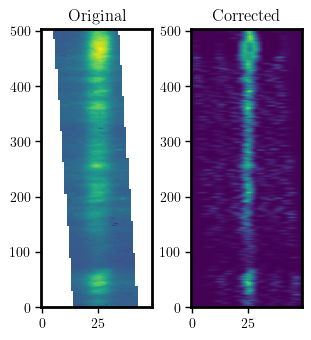

In [223]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(3,5),constrained_layout=True)

selet_column_number = 60
ax1.imshow(spice_dat1[selet_column_number,:,:],origin="lower",aspect=1/4)
ax2.imshow(spice_corr_dat[selet_column_number,:,:],origin="lower",aspect=1/4)
ax1.set_title("Original")
ax2.set_title("Corrected")


In [110]:
NeVIII_origin_fitmodel = SpectrumFit2D(spice_NeVIII_770_window[0,14:32,200:-128,:].data.transpose([1,2,0]).astype(np.float32), NeVIII_770_window_wvl[14:32],
                                line_number=1,line_wvl_init=[770],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
NeVIII_origin_fitmodel.run_lse_mp(prev_init=False)

/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=Fa

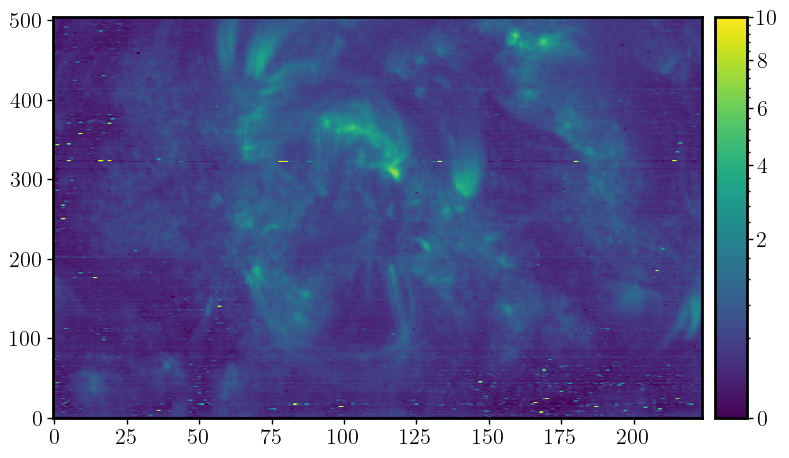

In [111]:
NeVIII_origin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=10,scale="sqrt",
                                  aspect=NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1)

Doppler velocity corrected by the median of each raster.


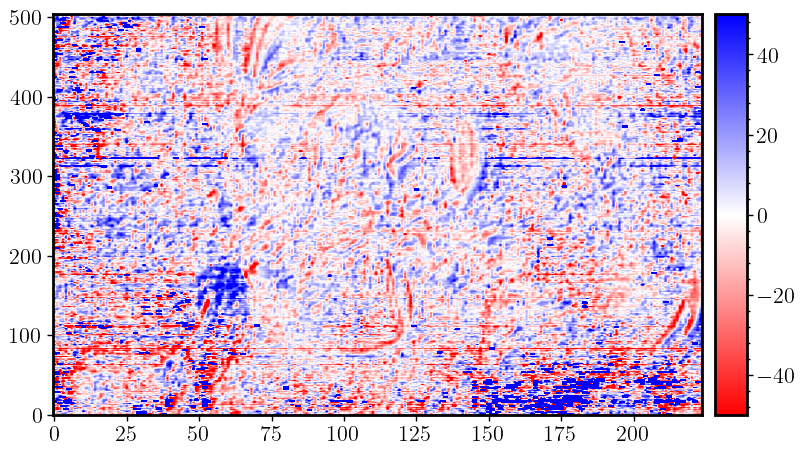

In [129]:
NeVIII_origin_fitmodel.plot_fit2d(param="vel",vmin=-50,vmax=50,ref_wvl=770.03,vel_corr="column",
                                  aspect=NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1)

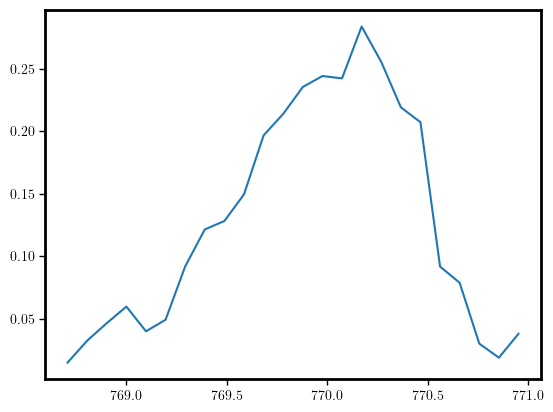

In [87]:
plt.plot(NeVIII_770_window_wvl[10:36],spice_NeVIII_770_window[0,10:36,300,100].data)

In [88]:
spice_corr_dat.shape

(224, 504, 50)

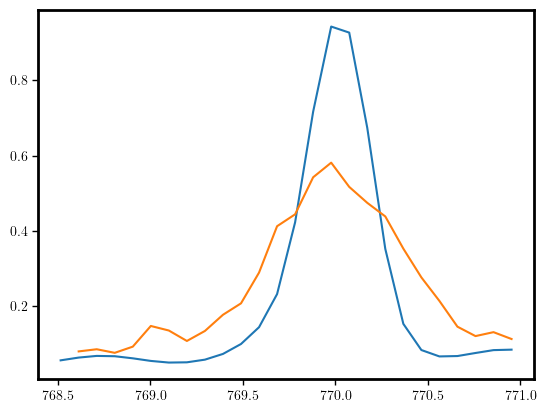

In [107]:
plt.plot(NeVIII_770_window_wvl[10:36],spice_corr_dat[100,200,10:36])
plt.plot(NeVIII_770_window_wvl[10:36],spice_dat1[100,200,10:36])

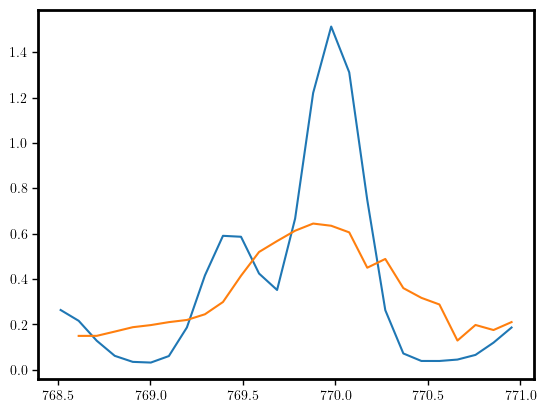

In [214]:
plt.plot(NeVIII_770_window_wvl[10:36],spice_corr_dat[60,170,10:36])
plt.plot(NeVIII_770_window_wvl[10:36],spice_dat1[60,170,10:36])

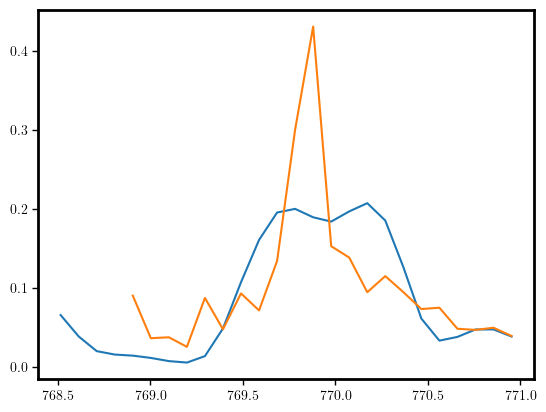

In [126]:
plt.plot(NeVIII_770_window_wvl[10:36],spice_corr_dat[190,20,10:36])
plt.plot(NeVIII_770_window_wvl[10:36],spice_dat1[190,20,10:36])

In [100]:
NeVIII_deconv_fitmodel = SpectrumFit2D(spice_corr_dat[:,:,12:34].transpose([1,0,2]).astype(np.float32), NeVIII_770_window_wvl[12:34],
                                line_number=1,line_wvl_init=[770],int_max_init=0.2,fwhm_init=1,
                                same_width=False)

NeVIII_deconv_fitmodel.run_lse_mp(prev_init=False)

/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=Fa

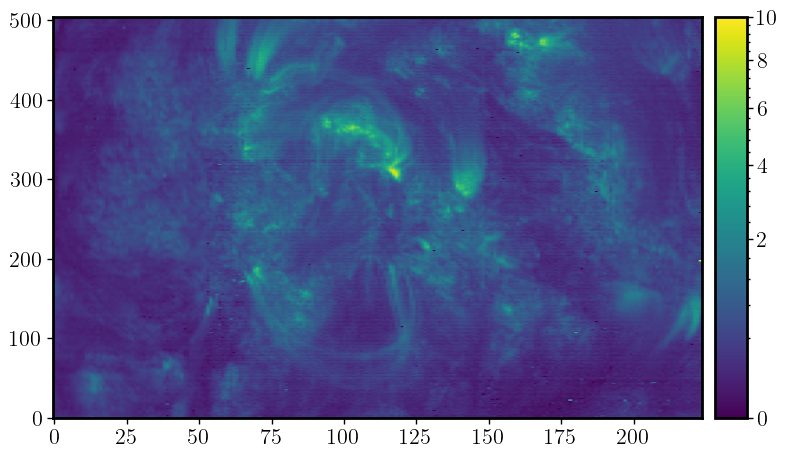

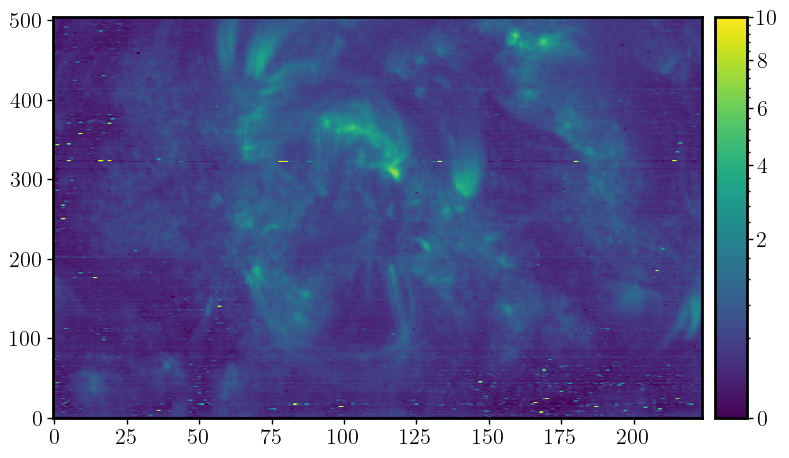

In [131]:
NeVIII_deconv_fitmodel.plot_fit2d(param="int",vmin=0,vmax=10,scale="sqrt",
                                    aspect=NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1) 
NeVIII_origin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=10,scale="sqrt",
                                    aspect=NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1)

Doppler velocity corrected by the median of the image.
Doppler velocity corrected by the median of the image.


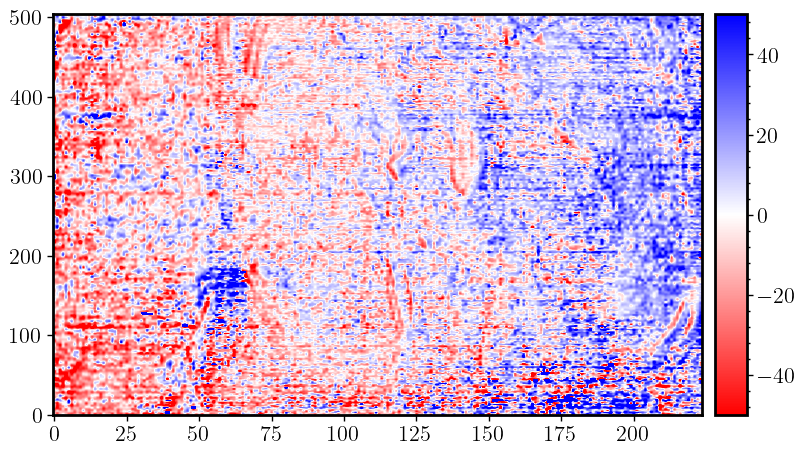

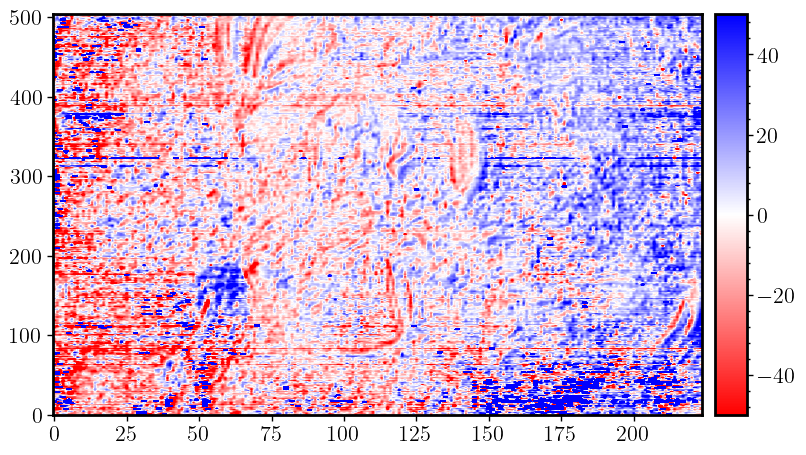

In [130]:
NeVIII_deconv_fitmodel.plot_fit2d(param="vel",vmin=-50,vmax=50,vel_corr="image",ref_wvl=770.03,
                                    aspect=NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1)
NeVIII_origin_fitmodel.plot_fit2d(param="vel",vmin=-50,vmax=50,vel_corr="image",ref_wvl=770.03,
                                    aspect=NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1)

Doppler velocity corrected by the median of each raster.


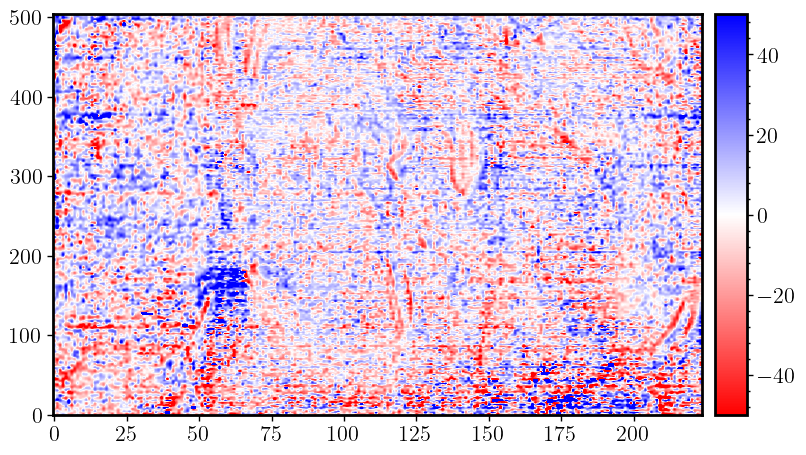

In [121]:
NeVIII_deconv_fitmodel.plot_fit2d(param="vel",vmin=-50,vmax=50,vel_corr="column",ref_wvl=770.03,
                                    aspect=NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1)

In [147]:
NeVIII_deconv_int_map = sunpy.map.Map(NeVIII_deconv_fitmodel.int_total_fit[:,:,0],
                                      NeVIII_770_window_rebin_map_crop.wcs)
NeVIII_deconv_int_map.plot_settings['cmap'] = "sdoaia171"
NeVIII_deconv_int_map.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=10,stretch=AsinhStretch(0.1))
NeVIII_deconv_int_map.plot_settings['aspect'] = NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1

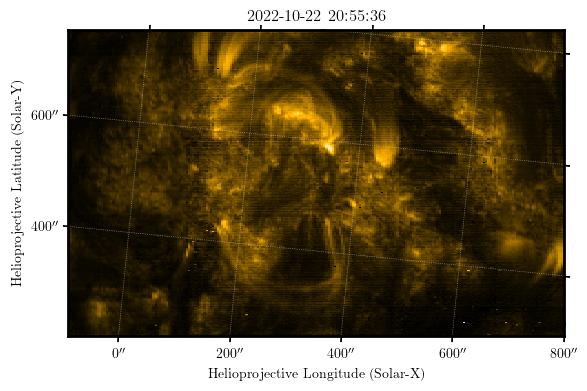

In [148]:
NeVIII_deconv_int_map.plot()

In [127]:
NeVIII_deconv_int_map.save("../../src/SPICE/20221022/lvl3/NeVIII_770_deconv_int_map_205536.fits",overwrite=True)

In [142]:
NeVIII_deconv_vel_map_data = (NeVIII_deconv_fitmodel.line_wvl_fit[:,:,0] - 770.065)/770.065*const.c.to("km/s").value
NeVIII_deconv_vel_map_data = NeVIII_deconv_vel_map_data - np.nanmedian(NeVIII_deconv_vel_map_data,axis=0)[np.newaxis,:]

In [149]:
NeVIII_deconv_vel_map = sunpy.map.Map(NeVIII_deconv_vel_map_data,
                                        NeVIII_770_window_rebin_map_crop.wcs)
NeVIII_deconv_vel_map.plot_settings['cmap'] = "RdBu_r"
NeVIII_deconv_vel_map.plot_settings['norm'] = ImageNormalize(vmin=-50,vmax=50)
NeVIII_deconv_vel_map.plot_settings['aspect'] = NeVIII_770_window_rebin_map_crop.scale.axis2/NeVIII_770_window_rebin_map_crop.scale.axis1

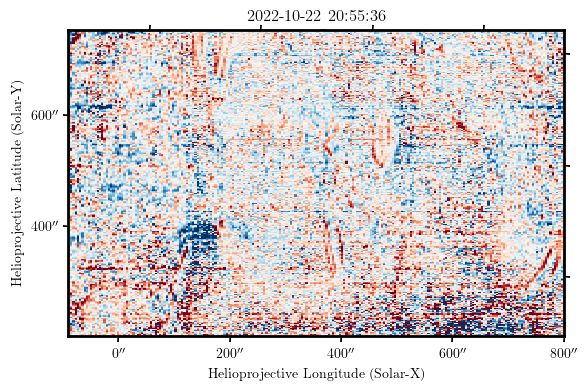

In [150]:
NeVIII_deconv_vel_map.plot()

In [151]:
NeVIII_deconv_vel_map.save("../../src/SPICE/20221022/lvl3/NeVIII_770_deconv_vel_map_205536_columncorr.fits",overwrite=True)

In [152]:
SunBlinker(NeVIII_deconv_int_map, NeVIII_deconv_vel_map)

In [153]:
spice_corr_dat.shape

(224, 504, 50)

In [154]:
NeVIII_deconv_data_rebin = np.nanmean(spice_corr_dat.reshape(224,-1,4,50),axis=2)

In [170]:
NeVIII_deconv_data_rebin.shape

(224, 126, 50)

In [155]:
NeVIII_770_window_rebin_map_crop.center

<SkyCoord (Helioprojective: obstime=2022-10-22T20:55:36.524, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-22T20:55:36.524, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-57.94609159, 5.63176251, 5.52257057e+10)>): (Tx, Ty) in arcsec
    (328.28018558, 522.88373146)>

In [156]:
NeVIII_770_window_rebin_map_crop.scale

SpatialPair(axis1=<Quantity 4. arcsec / pix>, axis2=<Quantity 1.098 arcsec / pix>)

In [157]:
NeVIII_deconv_data_rebin_center = deepcopy(NeVIII_770_window_rebin_map_crop.center)

In [173]:
NeVIII_deconv_data_rebin_center

<SkyCoord (Helioprojective: obstime=2022-10-22T20:55:36.524, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-22T20:55:36.524, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-57.94609159, 5.63176251, 5.52257057e+10)>): (Tx, Ty) in arcsec
    (328.28018558, 522.88373146)>

In [162]:
NeVIII_deconv_data_rebin_scale = u.Quantity((NeVIII_770_window_rebin_map_crop.scale.axis1,NeVIII_770_window_rebin_map_crop.scale.axis2*4))

In [188]:
NeVIII_deconv_data_rebin_rmatrix = deepcopy(NeVIII_770_window_rebin_map_crop.rotation_matrix)
NeVIII_deconv_data_rebin_rmatrix[0,1] = NeVIII_deconv_data_rebin_rmatrix[0,1]*4
NeVIII_deconv_data_rebin_rmatrix[1,0] = NeVIII_deconv_data_rebin_rmatrix[1,0]/4

In [189]:
NeVIII_deconv_data_rebin_rmatrix

array([[ 0.99506785, -0.10891792],
       [ 0.09034303,  0.99506785]])

In [190]:
NeVIII_deconv_data_rebin_header = sunpy.map.make_fitswcs_header(NeVIII_deconv_data_rebin[:,:,0].T.shape,
                                                      NeVIII_deconv_data_rebin_center,
                                                        scale=NeVIII_deconv_data_rebin_scale,
                                                        rotation_matrix=NeVIII_deconv_data_rebin_rmatrix)
NeVIII_deconv_data_rebin_wcs = WCS(NeVIII_deconv_data_rebin_header)

In [191]:
NeVIII_deconv_data_rebin_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.09118894043885317 0.14524548096085568 
CRPIX : 112.5 63.5 
PC1_1 PC1_2  : 0.995067849204 -0.1089179223052 
PC2_1 PC2_2  : 0.09034303328875 0.995067849204 
CDELT : 0.0011111111111111111 0.0012200000000000002 
NAXIS : 224  126

In [177]:
NeVIII_deconv_rebin_fitmodel = SpectrumFit2D(NeVIII_deconv_data_rebin[:,:,12:34].transpose([1,0,2]).astype(np.float32), NeVIII_770_window_wvl[12:34],
                                line_number=1,line_wvl_init=[770],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
NeVIII_deconv_rebin_fitmodel.run_lse_mp(prev_init=False)

/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=Fa

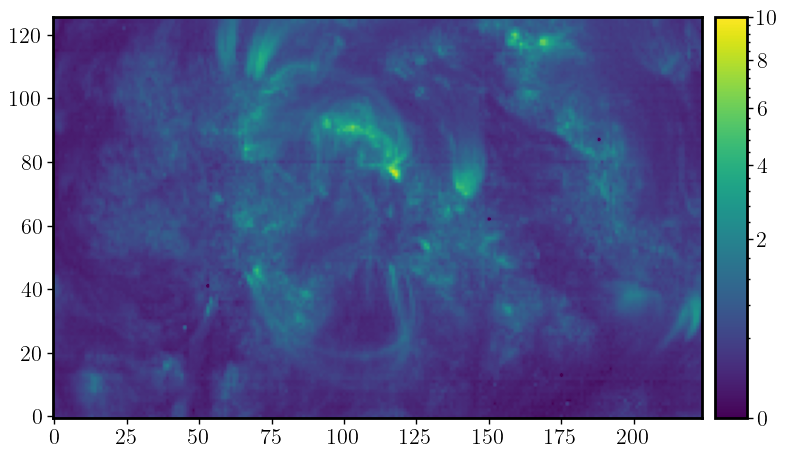

In [178]:
NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=10,scale="sqrt",
                                    aspect=NeVIII_deconv_data_rebin_scale[1]/NeVIII_deconv_data_rebin_scale[0])

Doppler velocity corrected by the median of each raster.


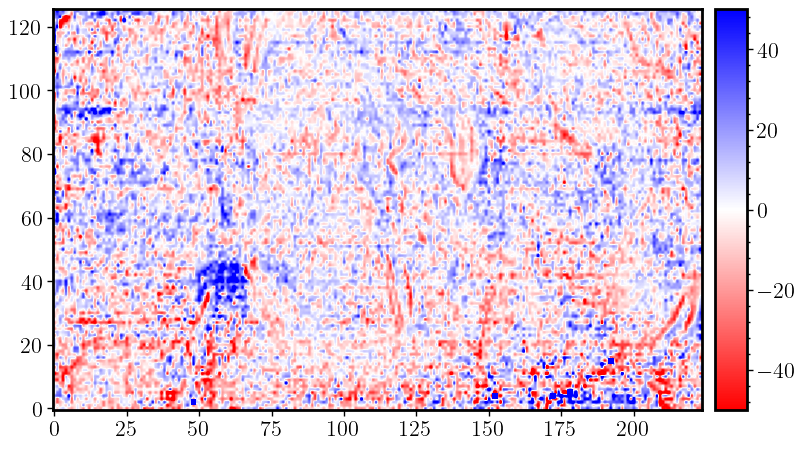

In [180]:
NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="vel",vmin=-50,vmax=50,vel_corr="column",ref_wvl=770.03,   
                                    aspect=NeVIII_deconv_data_rebin_scale[1]/NeVIII_deconv_data_rebin_scale[0])

In [192]:
NeVIII_deconv_rebin_int_map = sunpy.map.Map(NeVIII_deconv_rebin_fitmodel.int_total_fit[:,:,0],
                                        NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_int_map.plot_settings['cmap'] = "sdoaia171"
NeVIII_deconv_rebin_int_map.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=10,stretch=AsinhStretch(0.1))
NeVIII_deconv_rebin_int_map.plot_settings['aspect'] = NeVIII_deconv_data_rebin_scale[1]/NeVIII_deconv_data_rebin_scale[0]

In [193]:
NeVIII_deconv_data_rebin_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.09118894043885317 0.14524548096085568 
CRPIX : 112.5 63.5 
PC1_1 PC1_2  : 0.995067849204 -0.1089179223052 
PC2_1 PC2_2  : 0.09034303328875 0.995067849204 
CDELT : 0.0011111111111111111 0.0012200000000000002 
NAXIS : 224  126

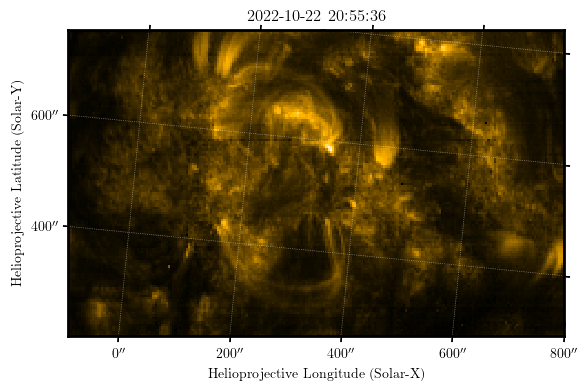

In [195]:
NeVIII_deconv_rebin_int_map.plot()

In [196]:
NeVIII_deconv_rebin_vel_map_column_corr_data = (NeVIII_deconv_rebin_fitmodel.line_wvl_fit[:,:,0] - 770.065)/770.065*const.c.to("km/s").value
NeVIII_deconv_rebin_vel_map_column_corr_data = NeVIII_deconv_rebin_vel_map_column_corr_data - \
    np.nanmedian(NeVIII_deconv_rebin_vel_map_column_corr_data,axis=0)[np.newaxis,:]

In [197]:
NeVIII_deconv_rebin_vel_map_column_corr = sunpy.map.Map(NeVIII_deconv_rebin_vel_map_column_corr_data,
                                        NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_vel_map_column_corr.plot_settings['cmap'] = "RdBu_r"
NeVIII_deconv_rebin_vel_map_column_corr.plot_settings['norm'] = ImageNormalize(vmin=-50,vmax=50)
NeVIII_deconv_rebin_vel_map_column_corr.plot_settings['aspect'] = NeVIII_deconv_data_rebin_scale[1]/NeVIII_deconv_data_rebin_scale[0]

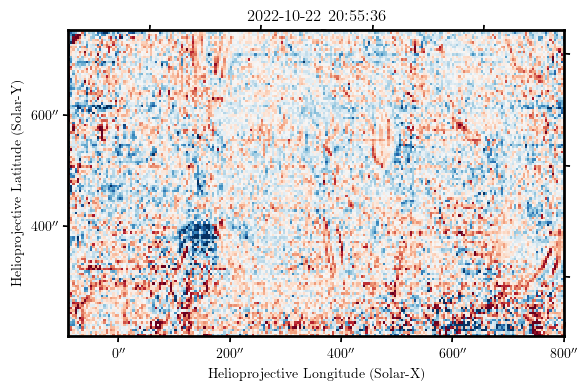

In [198]:
NeVIII_deconv_rebin_vel_map_column_corr.plot()

In [199]:
SunBlinker(NeVIII_deconv_rebin_int_map, NeVIII_deconv_rebin_vel_map_column_corr)